# Plotting RBush

We want to see the structure of a RBush -- we want to plot the 2D spatial distribution of the items in a RBush tree.

We'll do that using [datashader][ds] and its companions, [xarray][xr], [bokeh][bk], [holoviews][hv], [pandas][pd], [numpy][np].

This exercise is based on:
* https://anaconda.org/jbednar/plotting_pitfalls/notebook
* https://anaconda.org/jbednar/pipeline/notebook

After a first approach, investigate/exercise the following:
* does bokeh-webgl engine support Rectangle glyph?


[ds]: http://datashader.readthedocs.io/
[xr]: http://xarray.pydata.org/
[bk]: https://bokeh.pydata.org
[hv]: http://holoviews.org/
[pd]: https://pandas.pydata.org/
[np]: http://www.numpy.org/

In [1]:
import datashader as ds
import xarray as xr
import bokeh as bk
import pandas as pd
import numpy as np
from numba import njit
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

import rbush
from rbush.data import generate_data_array

In [2]:
print(ds.__version__)
print(xr.__version__)
print(bk.__version__)
print(pd.__version__)
print(np.__version__)

0.6.2
0.10.0
0.12.13
0.20.3
1.13.1


[RBush](https://github.com/parietal-io/py-rbush)
```
rbush.__version__ : '0.0.2+9.g355496a'
```

In [3]:
import rbush

In [4]:
from rbush.data import generate_data_array

N = int(1e5)
INCREMENT = 1000
SIZE = 100

arrays = []

# bottom-left
arr = generate_data_array(N, SIZE)
arr += SIZE
arrays.append(arr)

# top-right
arr = generate_data_array(N, SIZE)
arr += INCREMENT - SIZE
arrays.append(arr)

# bottom-right
arr = generate_data_array(N, SIZE)
arr[:,0] += INCREMENT - SIZE
arr[:,1] += SIZE
arr[:,2] += INCREMENT - SIZE
arr[:,3] += SIZE
arrays.append(arr)
    
# top-left
arr = generate_data_array(N, SIZE)
arr[:,0] += SIZE
arr[:,1] += INCREMENT - SIZE
arr[:,2] += SIZE
arr[:,3] += INCREMENT - SIZE
arrays.append(arr)

# top-middle
arr = generate_data_array(N, SIZE)
arr[:,0] += INCREMENT // 2
arr[:,1] += INCREMENT - SIZE
arr[:,2] += INCREMENT // 2
arr[:,3] += INCREMENT - SIZE
arrays.append(arr)

# bottom-middle
arr = generate_data_array(N, SIZE)
arr[:,0] += INCREMENT // 2
arr[:,1] += SIZE
arr[:,2] += INCREMENT // 2
arr[:,3] += SIZE
arrays.append(arr)

# left-middle
arr = generate_data_array(N, SIZE)
arr[:,0] += SIZE
arr[:,1] += INCREMENT // 2
arr[:,2] += SIZE
arr[:,3] += INCREMENT // 2
arrays.append(arr)

    
data = np.concatenate(arrays, axis=0)
print('Length: {:,}'.format(len(data)))
data

Length: 700,000


array([[ 193.32809439,  172.38902886,  120.27373246,   56.83204338],
       [  12.97762763,  121.66349512,  -22.37162773,  250.14395374],
       [ 122.71754339,  133.48912108,  214.87462481,   98.9385329 ],
       ..., 
       [  71.00865859,  494.16927138,  322.32780519,  520.31681527],
       [ 170.09535971,  489.58834376,  206.74470196,  155.40630456],
       [  13.06548951,  504.63168698,  108.37843854,  576.39775501]])

In [5]:
t = rbush.RBush()
t.load(data)

In [6]:
items = t.all()

# TODO: "retrieve-all" output should be an array (like the input 'data', apart from permutations)

bboxes = np.asarray([[i.xmin, i.ymin, i.xmax, i.ymax] for i in items])
bboxes

array([[-140.71046276, -193.72598348, -185.5710116 , -305.24281777],
       [-157.50464743, -179.48997844, -187.10403737, -130.66775286],
       [-141.12044038, -164.90717807,  -87.67851902, -254.22625082],
       ..., 
       [-157.50464743, -179.48997844, -187.10403737, -130.66775286],
       [-218.00814448, -128.27594684, -238.14947485, -151.17786293],
       [  13.06548951,  504.63168698,  108.37843854,  576.39775501]])

In [7]:
# Apart from (raw) permutations, 'data' and 'bboxes' should contain the same information
assert data.shape==bboxes.shape

In [8]:
print(data.min(axis=0))
print(data.max(axis=0))
print(data.mean(axis=0))

[-351.69133522 -347.13225396 -541.19136452 -535.65428175]
[ 1314.61938497  1394.97388555  1519.23539564  1546.41435327]
[ 442.85102024  500.17033107  442.87102565  500.36178719]


In [9]:
print(bboxes.min(axis=0))
print(bboxes.max(axis=0))
print(bboxes.mean(axis=0))

[-218.00814448 -239.06428163 -351.85877354 -307.13417565]
[ 596.4593167   504.63168698  621.56610633  576.39775501]
[-156.19430466 -144.37281157 -170.35009038 -144.51973373]


**We see now that RBush has a (big) bug!** To not deviate from our exercise, let's use the `data` array, it's the same structure (as `bboxes`)

Datashader works in a canvas represented by an `xarray` where each element is a bin.
The bin represents a pixel in a (data) coordinates system.
Each bin contains information aggregated from the dataset(s) at that (pixel) position.

Let's say we want to count the number of items (bounding-boxes in our dataset) that cover each position in the dataset parameters space (xmin,ymin,xmax,ymax) -- a heatmap of the items distribution.
Each bin in the datashader (xarray) canvas will contain the number counts.

As a first approach, let's do the representation of items' centroids.
Then we evolve to plotting the boxes' coverage area.

In [10]:
df = pd.DataFrame(data, columns=['xmin','ymin','xmax','ymax'])
df['x'] = df[['xmin','xmax']].mean(axis=1)
df['y'] = df[['ymin','ymax']].mean(axis=1)

In [11]:
# We will represent centroids
glyph = ds.glyphs.Point('x', 'y')
glyph

In [12]:
# Say we want to see in a resolution of "1 data-unit" of the (variable) data axes range
# TODO: Numba-isze this and take sizes / resolution.
xres = 1
yres = 1

BORDER = 100
xlims = [int(df.xmin.min()) - BORDER, int(df.xmax.max()+1) + BORDER]
ylims = [int(df.ymin.min()) - BORDER, int(df.ymax.max()+1) + BORDER]

xsize = (xlims[1] - xlims[0])//xres
ysize = (ylims[1] - ylims[0])//yres


def def_pos2pix(pmin,res):
    pos_zero = int(pmin/res)
    def f(pos):
        return int(pos/res) - pos_zero
    return f


def def_pix2pos(pmin,res):
    def f(pix):
        return pix*res + pmin
    return f

pos2pix_x = def_pos2pix(xlims[0], xres)
pos2pix_y = def_pos2pix(ylims[0], yres)

pix2pos_x = def_pix2pos(xlims[0], xres)
pix2pos_y = def_pix2pos(ylims[0], yres)

In [13]:
canvas = ds.Canvas(plot_width=800, plot_height=400, x_range=xlims, y_range=ylims)

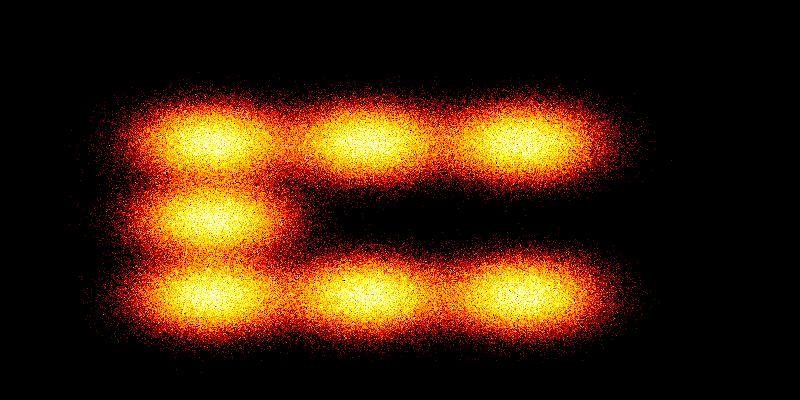

In [14]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

img = tf.shade(canvas.points(df,'x','y', agg=reductions.count()), cmap=Hot, how='eq_hist')
tf.set_background(img, 'black')

In [15]:

# TODO: Numba-isze this and take sizes / resolution. 
# TODO: fix x/y transpose issue shown below
a = np.zeros((xsize,ysize),dtype=int)

for i in range(len(data)):
    row = data[i]
#     print(row)
    xi = pos2pix_x(row[0])
    xf = pos2pix_x(row[2])
    yi = pos2pix_y(row[1])
    yf = pos2pix_y(row[3])
#     print(xi,yi,xf,yf)
    x0 = pix2pos_x(xi)
    y0 = pix2pos_y(yi)
    a[xi:xf,yi:yf] += 1


In [16]:
# Let's build an xarray from 'a'
# xarray have a coordinates attribute ('coords'), apart from dimensions ('dims')

xaxis = np.arange(xlims[0], xlims[1], xres)
yaxis = np.arange(ylims[0], ylims[1], yres)
axx = xr.DataArray(a, dims=['x','y'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (x: 2071, y: 2094)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) int64 -451 -450 -449 -448 -447 -446 -445 -444 -443 -442 ...
  * y        (y) int64 -447 -446 -445 -444 -443 -442 -441 -440 -439 -438 ...

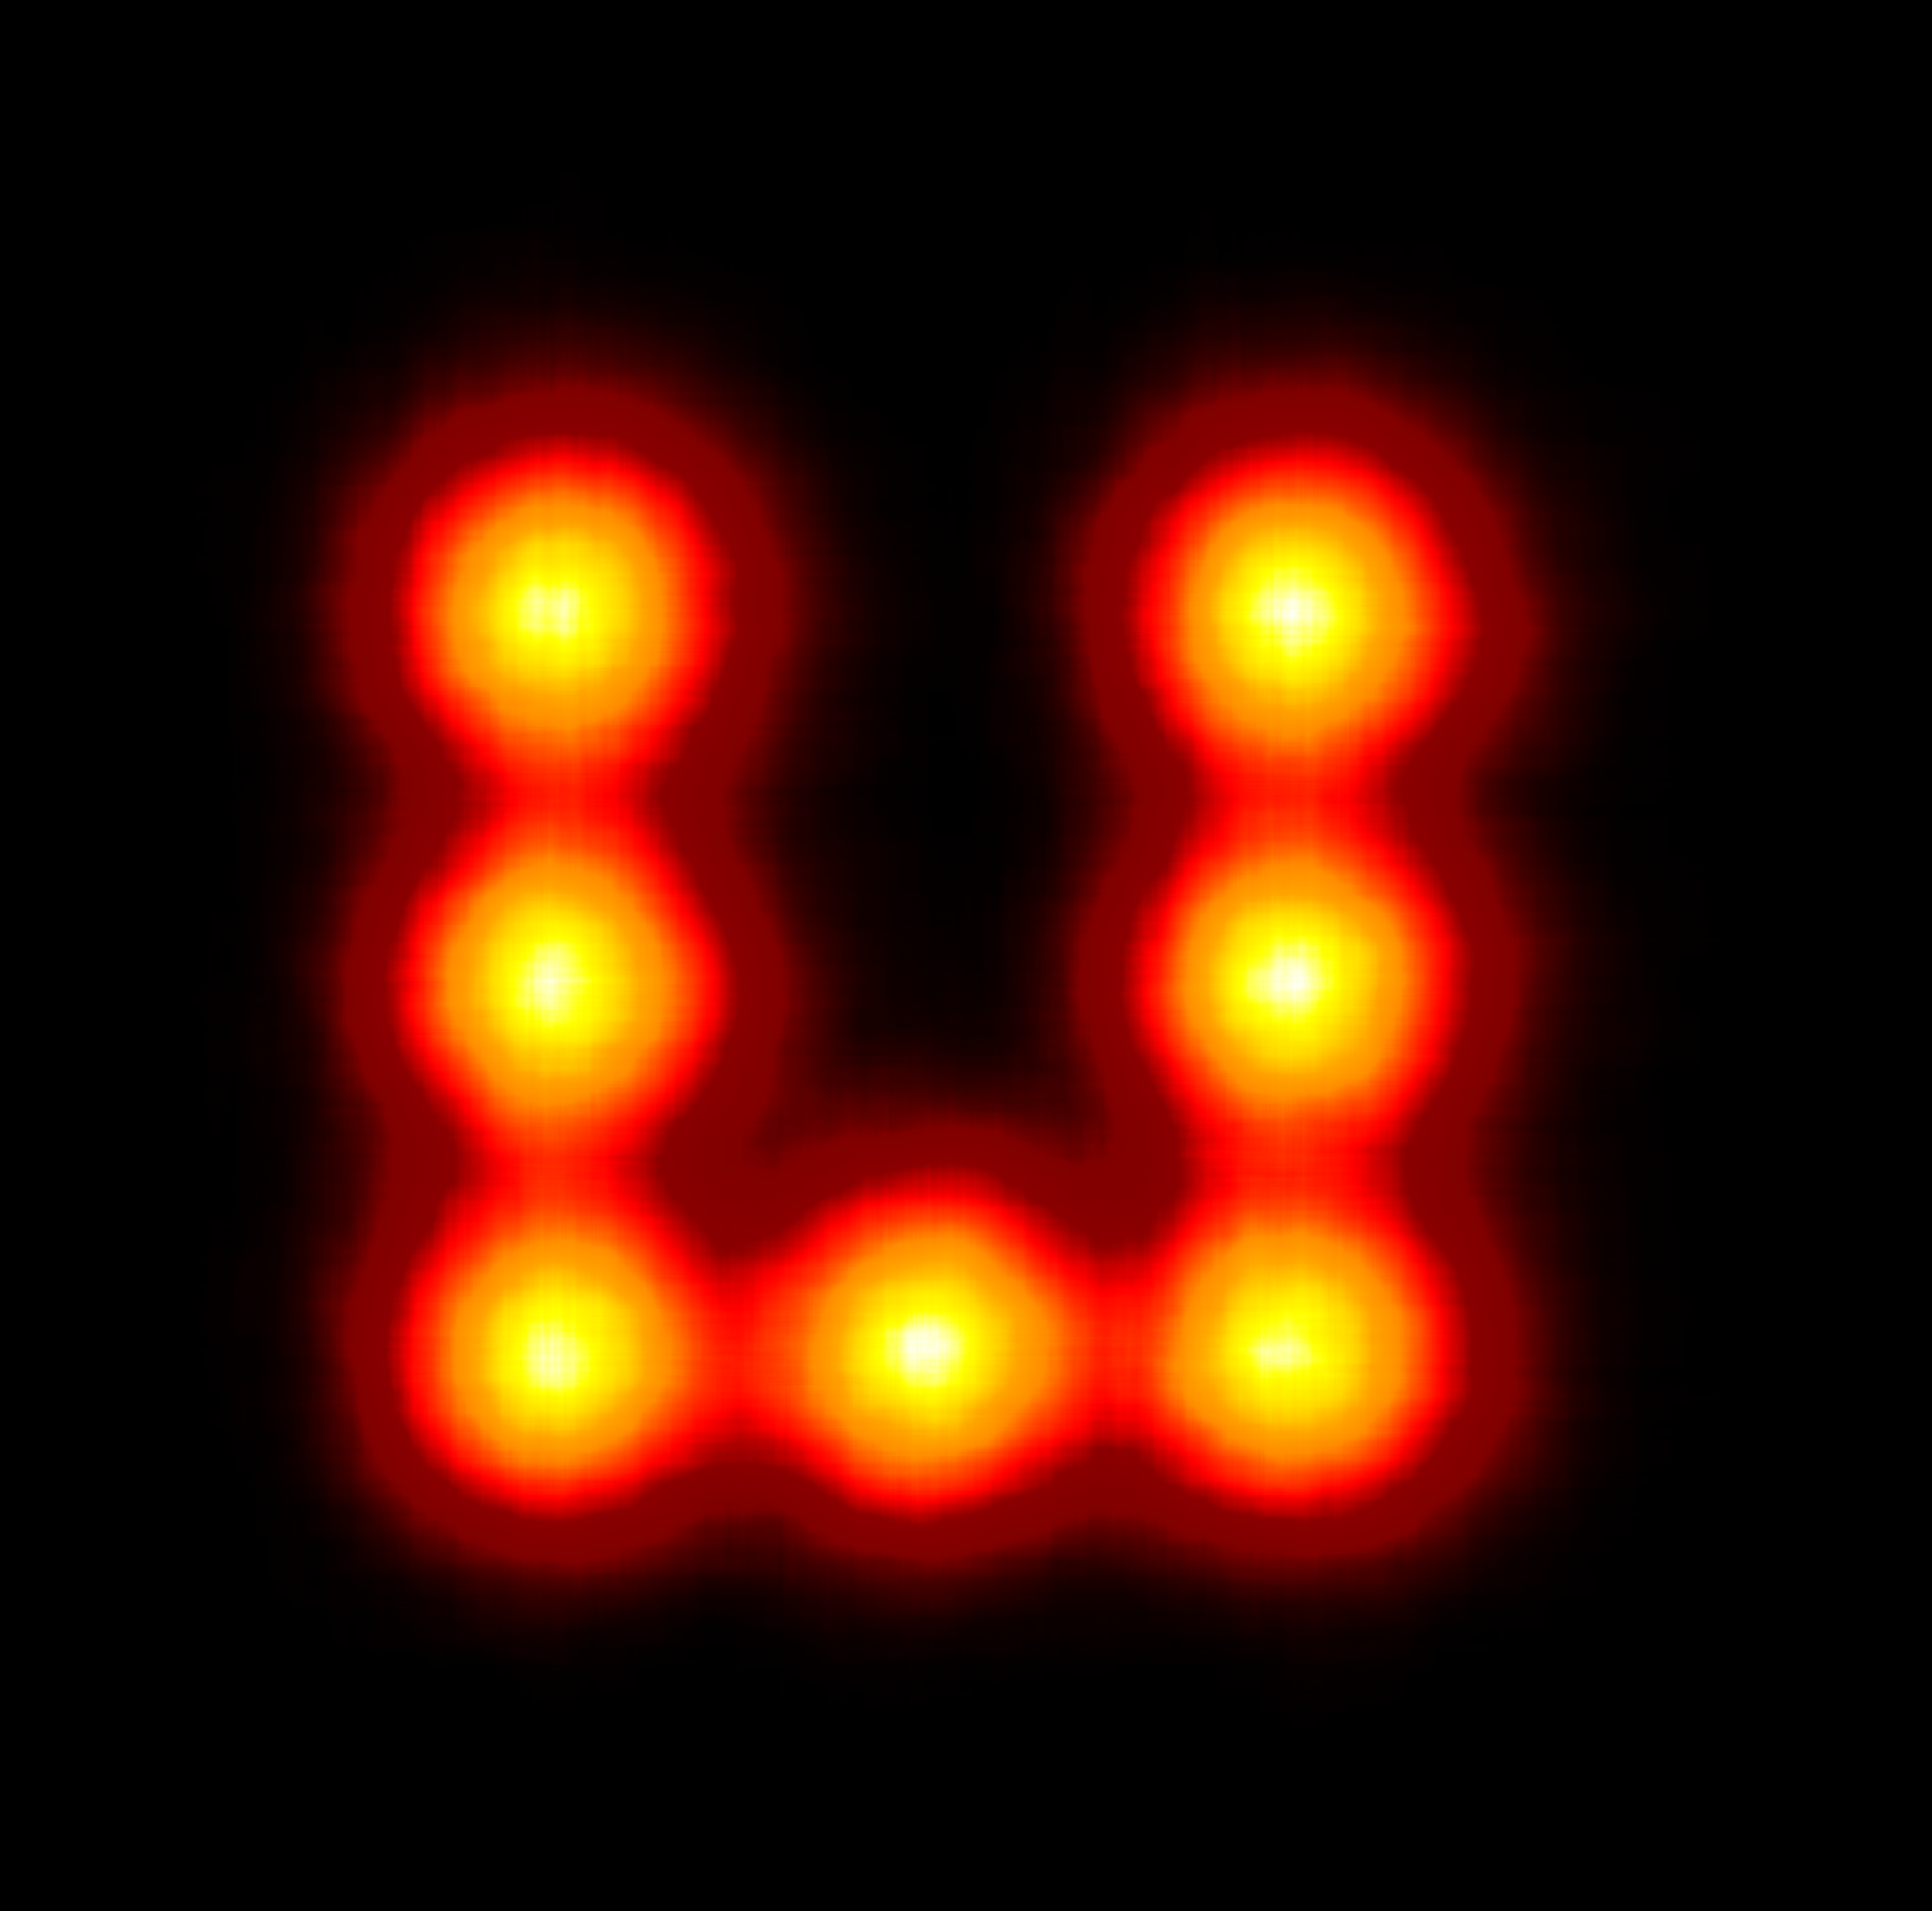

In [17]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')